In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

# 加載並標準化CIFAR10
# Torchvision數據集的輸出是[0, 1]範圍的PILImage, 必須將它們進行歸一化到[-1, 1]的Tensor
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(
    (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # compose疑似是把多個步驟整合在一起，此例就是先轉Tensor再做歸一化

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

170499072it [02:20, 1211238.11it/s]                               


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


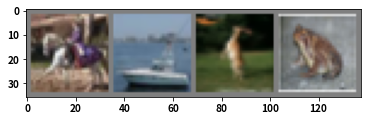

horse  ship  deer  frog


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()
# get some random training images
dataiter = iter(trainloader) #iter用於轉換以將可迭代對象轉換為迭代器
images, labels = dataiter.next() #iter()使用next()訪問值

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


## 定義卷積神經網路

In [18]:
#從3_NeuralNetwork的LeNet進行修改
import torch.nn as nn
import torch.nn.functional as F
# 定義網路
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [19]:
net = Net()

## 定義loss function and optimizer

In [20]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #使用分類交叉熵損失，並定義帶有動量的SGD優化器

## 訓練網路

In [21]:
# 遍歷數據迭代器，將輸入饋送到網路再進行優化
for epoch in range(2): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        output = net(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000)) #running_loss: 累積起來的loss
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.200
[1,  4000] loss: 1.829
[1,  6000] loss: 1.699
[1,  8000] loss: 1.633
[1, 10000] loss: 1.561
[1, 12000] loss: 1.505
[2,  2000] loss: 1.446
[2,  4000] loss: 1.411
[2,  6000] loss: 1.385
[2,  8000] loss: 1.354
[2, 10000] loss: 1.321
[2, 12000] loss: 1.319
Finished Training


## 保存模型

In [22]:
PATH = './save_models/cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 測試NN可用性

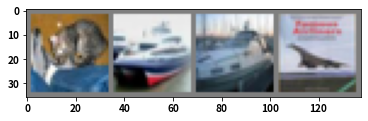

GroundTruth:    cat  ship  ship plane


In [23]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [24]:
# reload save_model
# 僅僅練習用，可以略過此步
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [25]:
outputs = net(images)

In [26]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4))) #5s代表5個字符，%5s代表輸出字符串至少要有5個 不夠左側用空格補!

Predicted:    cat  ship  ship  ship


In [33]:
# 結果統計
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1) #torch.max(a) 返回輸入a中所有元素的最大值，max(a, 0)返回每一列最大值且返回索引(各列的行)，max(a, 1)返回每一列最大值且返回所返回每一列最大值且返回索引(各行的列)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))



Accuracy of the network on the 10000 test images: 51 %


In [35]:
#哪些表現好、哪些不好？
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 59 %
Accuracy of   car : 60 %
Accuracy of  bird : 28 %
Accuracy of   cat : 52 %
Accuracy of  deer : 55 %
Accuracy of   dog : 17 %
Accuracy of  frog : 52 %
Accuracy of horse : 65 %
Accuracy of  ship : 56 %
Accuracy of truck : 68 %


## 在GPU上進行訓練

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 轉成GPU
print(device)

cuda:0


In [38]:
#使用方法來遍歷所有Module, 並將其參數與buffer轉換成cuda tensor
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [39]:
#輸入和目標也都要同步移動到GPU上
inputs, labels = data[0].to(device), data[1].to(device)

In [40]:
# 接下來就可以使用GPU來訓練使用網路了